In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA


In [2]:
!pip install kagglehub

### LOAD DATASET

In [4]:
import kagglehub
path = kagglehub.dataset_download("rohiteng/spotify-music-analytics-dataset-20152025")

In [6]:
path

'C:\\Users\\user\\.cache\\kagglehub\\datasets\\rohiteng\\spotify-music-analytics-dataset-20152025\\versions\\1'

In [7]:
import os

os.listdir("C:\\Users\\user\\.cache\\kagglehub\\datasets\\rohiteng\\spotify-music-analytics-dataset-20152025\\versions\\1")

['spotify_2015_2025_85k.csv']

In [8]:

path = "C:\\Users\\user\\.cache\\kagglehub\\datasets\\rohiteng\\spotify-music-analytics-dataset-20152025\\versions\\1"

df = pd.read_csv(path + "\\spotify_2015_2025_85k.csv")

df.head()

,track_id,track_name,artist_name,album_name,release_date,genre,duration_ms,popularity,danceability,energy,key,loudness,mode,instrumentalness,tempo,stream_count,country,explicit,label
0,TRK-BEBD53DA84E1,Agent every (0),Noah Rhodes,Beautiful instead,2016-04-01,Pop,234194,55,0.15,0.74,9,-32.22,0,0.436,73.12,13000,Brazil,0,Universal Music
1,TRK-6A32496762D7,Night respond,Jennifer Cole,Table,2022-04-15,Metal,375706,45,0.44,0.46,0,-14.02,0,0.223,157.74,1000,France,1,Island Records
2,TRK-47AA7523463E,Future choice whatever,Brandon Davis,Page southern,2016-02-23,Rock,289191,55,0.62,0.80,8,-48.26,1,0.584,71.03,1000,Germany,1,XL Recordings
3,TRK-25ADA22E3B06,Bad fall pick those,Corey Jones,Spring,2015-10-12,Pop,209484,51,0.78,0.98,1,-34.47,1,0.684,149.00,1000,France,0,Warner Music
4,TRK-9245F2AD996A,Husband,Mark Diaz,Great prove,2022-07-08,Indie,127435,39,0.74,0.18,10,-17.84,0,0.304,155.85,2000,United States,0,Independent


In [9]:
df.shape

(85000, 19)

### BASIC CLEANING

In [11]:
df.isnull().sum()

track_id             0
track_name          21
artist_name          0
album_name          46
release_date         0
genre                0
duration_ms          0
popularity           0
danceability         0
energy               0
key                  0
loudness             0
mode                 0
instrumentalness     0
tempo                0
stream_count         0
country              0
explicit             0
label                0
dtype: int64

In [13]:
df['track_name'] = df['track_name'].fillna("Unknown")
df['album_name'] = df['album_name'].fillna("Unknown")
df.isnull().sum()

track_id            0
track_name          0
artist_name         0
album_name          0
release_date        0
genre               0
duration_ms         0
popularity          0
danceability        0
energy              0
key                 0
loudness            0
mode                0
instrumentalness    0
tempo               0
stream_count        0
country             0
explicit            0
label               0
dtype: int64

In [14]:
df = df.drop_duplicates()

In [15]:
df['release_date'] = pd.to_datetime(df['release_date'], errors='coerce')

In [16]:
# Extract year
df['release_year'] = df['release_date'].dt.year
# Convert explicit to boolean
df['explicit'] = df['explicit'].astype(bool)

# Duration in minutes
df['duration_min'] = df['duration_ms'] / 60000

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 85000 entries, 0 to 84999
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   track_id          85000 non-null  object        
 1   track_name        85000 non-null  object        
 2   artist_name       85000 non-null  object        
 3   album_name        85000 non-null  object        
 4   release_date      85000 non-null  datetime64[ns]
 5   genre             85000 non-null  object        
 6   duration_ms       85000 non-null  int64         
 7   popularity        85000 non-null  int64         
 8   danceability      85000 non-null  float64       
 9   energy            85000 non-null  float64       
 10  key               85000 non-null  int64         
 11  loudness          85000 non-null  float64       
 12  mode              85000 non-null  int64         
 13  instrumentalness  85000 non-null  float64       
 14  tempo             8500

### FEATURE ENGINEERING

In [28]:
# Select audio features
audio_features = [
    "danceability", "energy", "loudness", "instrumentalness",
    "tempo"
]

df_audio = df[audio_features]

# Normalize audio features
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df_audio)

df_scaled = pd.DataFrame(df_scaled, columns=audio_features)


### EDA — DISTRIBUTIONS

<Figure size 1000x600 with 0 Axes>

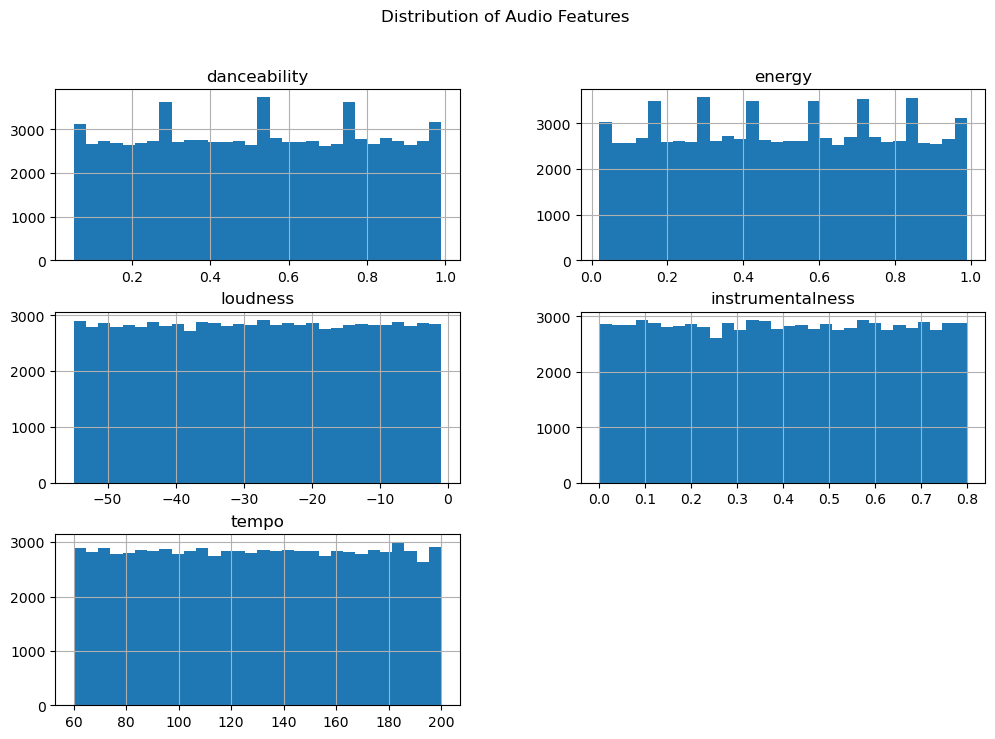

In [31]:
plt.figure(figsize=(10,6))
df[audio_features].hist(bins=30, figsize=(12,8))
plt.suptitle("Distribution of Audio Features")
plt.show()


### CORRELATION ANALYSIS

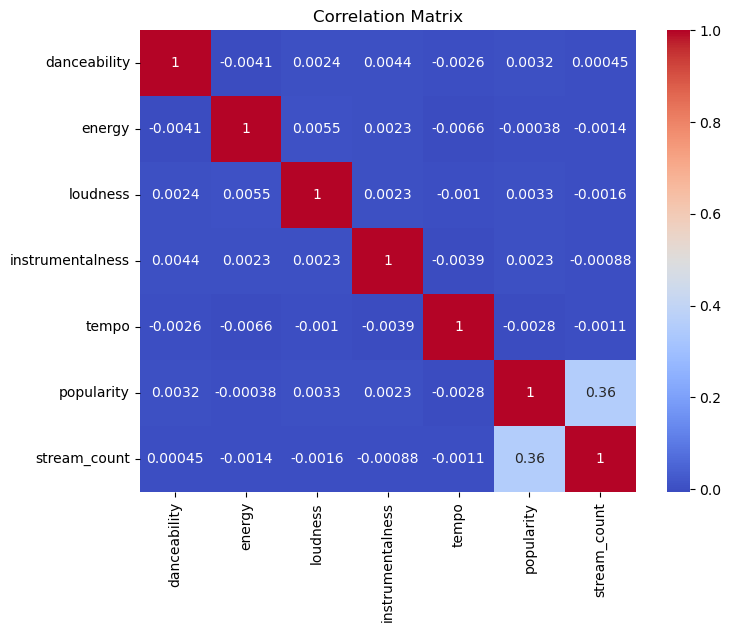

In [34]:
plt.figure(figsize=(8,6))
sns.heatmap(df[audio_features + ['popularity', 'stream_count']].corr(), 
            annot=True, cmap='coolwarm')
plt.title("Correlation Matrix")
plt.show()

### GENRE PROFILING

In [37]:
genre_profile = df.groupby("genre")[audio_features + ["popularity", "stream_count"]].mean()

genre_profile.sort_values("popularity", ascending=False).head()

,danceability,energy,loudness,instrumentalness,tempo,popularity,stream_count
genre,,,,,,,
Pop,0.519262,0.503248,-27.972482,0.396319,130.759667,48.367108,216763.105975
R&B,0.520205,0.504531,-28.094366,0.404750,130.250486,48.364342,229477.555054
Classical,0.519561,0.507925,-28.246822,0.404660,129.340365,48.364208,217722.967309
Hip-Hop,0.520560,0.505156,-28.053568,0.395470,130.266807,48.357402,266307.541899
EDM,0.520493,0.509820,-27.829160,0.400634,129.174117,48.204961,222381.201044


### CLUSTERING (KMeans)

In [40]:
kmeans = KMeans(n_clusters=5, random_state=42)
df['cluster'] = kmeans.fit_predict(df_scaled)

# Cluster centers
centers = pd.DataFrame(kmeans.cluster_centers_, columns=audio_features)
centers

C:\Users\user\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] The system cannot find the file specified
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "C:\Users\user\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
               ^^^^^^^^^^^^^^^
  File "C:\Users\user\anaconda3\Lib\subprocess.py", line 548, in run
    with Popen(*popenargs, **kwargs) as process:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\user\anaconda3\Lib\subprocess.py", line 1026, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "C:\Users\user\anaconda3\Lib\subprocess.py", line 1538, in _execute_child
    hp, ht, pid, tid = _winapi.CreateProcess(

,danceability,energy,loudness,instrumentalness,tempo
0,0.091950,-0.901175,0.790245,0.002250,-0.636712
1,0.965161,0.029083,-0.017261,0.005335,0.946260
2,-0.900454,-0.452246,-0.687446,-0.062870,0.604272
3,-0.555862,0.939298,0.808265,0.021013,-0.033161
4,0.372598,0.373054,-0.866494,0.034015,-0.902434


In [42]:
# Cluster median profiles
cluster_profile = df.groupby("cluster")[[
    "danceability","energy","loudness","instrumentalness","tempo"
]].median()

# Assign human-readable labels
cluster_labels = {
    0: "High Energy & Danceable",
    1: "Soft / Acoustic",
    2: "Balanced Mainstream",
    3: "Instrumental / Ambient",
    4: "High Tempo Electronic"
}

df["cluster_label"] = df["cluster"].map(cluster_labels)

#### PCA FOR 2D VISUALIZATION

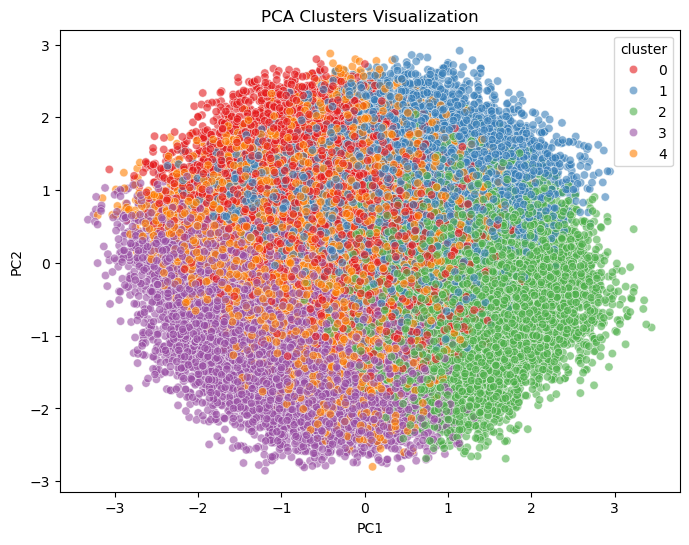

In [45]:
pca = PCA(n_components=2)
pca_components = pca.fit_transform(df_scaled)

df['PC1'] = pca_components[:,0]
df['PC2'] = pca_components[:,1]

plt.figure(figsize=(8,6))
sns.scatterplot(
    x='PC1', y='PC2',
    hue=df['cluster'],
    palette='Set1',
    data=df,
    alpha=0.6
)
plt.title("PCA Clusters Visualization")
plt.show()

### Genre analysis

In [47]:
# Genre audio profile
genre_audio = df.groupby("genre")[[
    "danceability","energy","loudness","instrumentalness","tempo"
]].mean().reset_index()

# Top genres by popularity
top_genres_popularity = (
    df.groupby("genre")["popularity"]
    .mean()
    .sort_values(ascending=False)
    .reset_index()
)

# Genre distribution inside clusters
genres_in_clusters = (
    df.groupby(["cluster_label", "genre"])["track_id"]
    .count()
    .reset_index()
    .rename(columns={"track_id": "tracks_in_cluster"})
)

### EXPORT FINAL FILE FOR TABLEAU

In [50]:
df.head()

,track_id,track_name,artist_name,album_name,release_date,genre,duration_ms,popularity,danceability,energy,...,stream_count,country,explicit,label,release_year,duration_min,cluster,cluster_label,PC1,PC2
0,TRK-BEBD53DA84E1,Agent every (0),Noah Rhodes,Beautiful instead,2016-04-01,Pop,234194,55,0.15,0.74,...,13000,Brazil,False,Universal Music,2016,3.903233,3,Instrumental / Ambient,-0.892100,-1.436121
1,TRK-6A32496762D7,Night respond,Jennifer Cole,Table,2022-04-15,Metal,375706,45,0.44,0.46,...,1000,France,True,Island Records,2022,6.261767,3,Instrumental / Ambient,0.471799,-0.458234
2,TRK-47AA7523463E,Future choice whatever,Brandon Davis,Page southern,2016-02-23,Rock,289191,55,0.62,0.80,...,1000,Germany,True,XL Recordings,2016,4.819850,4,High Tempo Electronic,-1.214920,0.047706
3,TRK-25ADA22E3B06,Bad fall pick those,Corey Jones,Spring,2015-10-12,Pop,209484,51,0.78,0.98,...,1000,France,False,Warner Music,2015,3.491400,1,Soft / Acoustic,-1.207140,0.315586
4,TRK-9245F2AD996A,Husband,Mark Diaz,Great prove,2022-07-08,Indie,127435,39,0.74,0.18,...,2000,United States,False,Independent,2022,2.123917,1,Soft / Acoustic,0.712177,1.053937


In [53]:
df.to_csv("spotify_prepared_for_tableau.csv", index=False)
print("Exported successfully!")

Exported successfully!
